# Exercise Sheet No. 4

---

> Machine Learning for Natural Sciences, Summer 2023, Jun.-Prof. Pascal Friederich
> 
> Deadline: May 15th 2023, 8am
>
> Container version 1.0.0
>
> Tutor: chen.zhou@kit.edu
>
> **Please ask questions in the forum/discussion board and only contact the Tutor when there are issues with the grading**


---

**Topic**: 
This exercise sheet (24 points in total) will focus on the math basics for ML. You will implement another simple ML algorithm, **linear regression** (LR), instead of decision tree to work on the same task you have already seen in exercise 02. **Gradient decent**, **mean square error loss function**, and **mean absolute error function** are covered in this exercise. And you will learn to use **ridge regression** to control overfitting.

Please add here your group members' names and student IDs. 

Names: Robin Maurer, Francisca Azocar Dannemann, Marcus Fledler

IDs: 2462304, 2480646, 2494460


# Linear Regression
In assignment 2, we have seen the use of decision tree for iris species classification. Now, let's try to solve the same problem with another simple machine learning technique: linear regression (LR).   

As you may have already learned from the lecture, linear regression uses a linear combination of features to predict a target. In our case we can use a linear combination of the four flower descriptors to predict the species.

In this assignment, you will learn to implement the Loss function and Gradient Decent for optimization. Then, we will see that even small model like LR can overfit, and how regularization (ridge regression) can help against this problem.

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from functools import wraps
warnings.filterwarnings('ignore')

## Preprocessing
Let's start with preprocessing the dataset, as already learned from assignment 2.

In [2]:
def log_name(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\n{func.__name__}:")
        return result
    return wrapper

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tshape: {result.shape}")
        return result
    return wrapper

def log_columns(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tcolumns: {result.columns.values}")
        return result
    return wrapper

@log_columns
@log_shape
@log_name
def load(df, path):
    """Loads the dataset from path."""
    df = pd.read_csv(path)
    return df

@log_columns
@log_shape
@log_name
def convert_to_categorical(df, col_name: str):
    df[col_name] = df[col_name].astype('category')
    return df

@log_columns
@log_shape
@log_name
def add_class_labels(df):
    df['class'] = df['species'].cat.codes
    return df

In [3]:
df = pd.DataFrame()
df = (
    df.pipe(load, 'iris.csv')
      .pipe(convert_to_categorical, 'species')
      .pipe(add_class_labels)
)


load:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

convert_to_categorical:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

add_class_labels:
	shape: (150, 6)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species'
 'class']


## Plot the data
It is always a good practice to have some inspection on the dataset. This provides us with information about the data such as its structure, range, outliers etc., which may help on the design of ML algorithm. There are numerous ways to visualize data, and introduced here is the one called "Pairplot", which displays pairwise relationships in a dataset (you probably have already seen it in lecture slides). Pairplot can be implemented easily with the [seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) library. Here we used it to show the pairwise relationships among iris features.

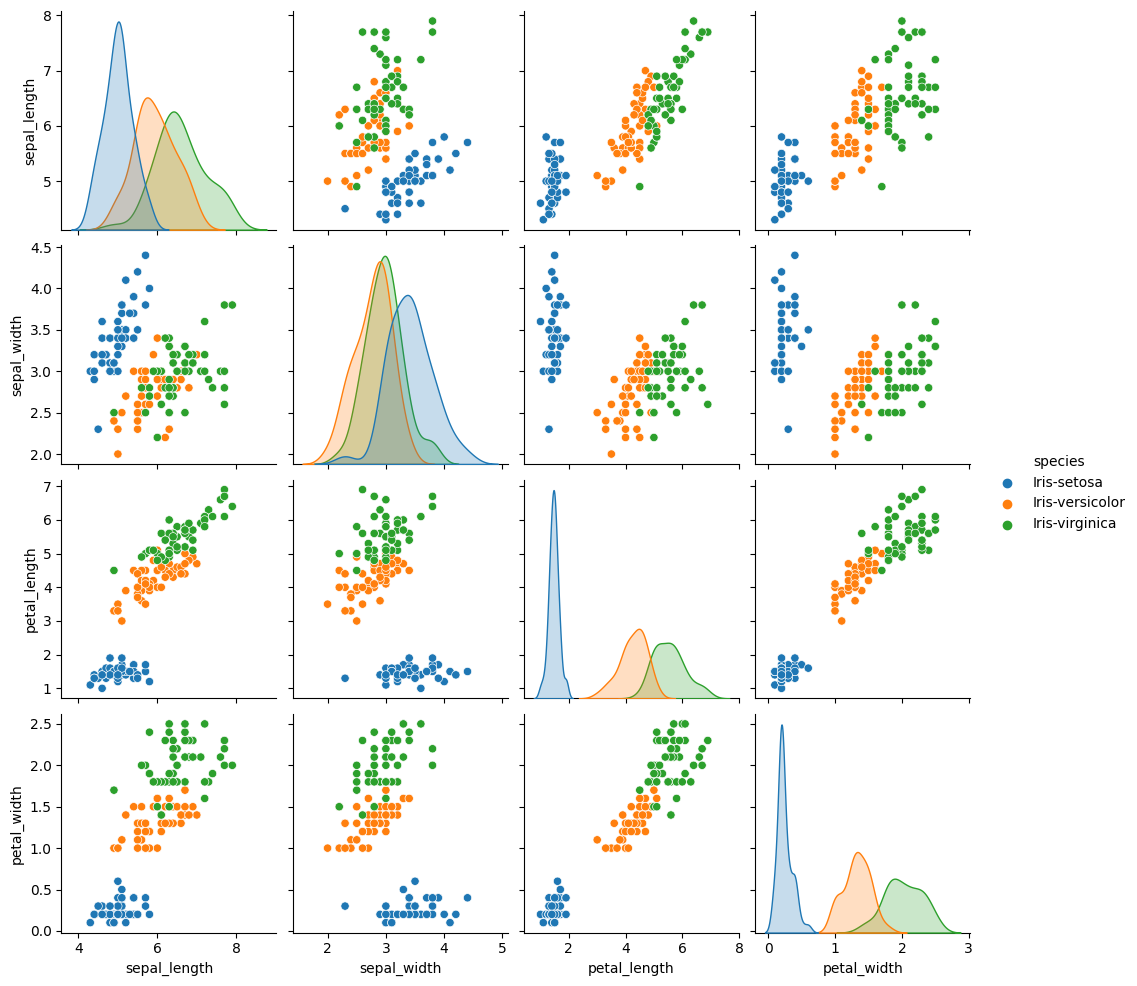

In [5]:
sns.pairplot(df.loc[:,:'species'], hue= 'species')
plt.show()

**Question**: out of these combinations of features, which pair has the strongest linear correlation relationship?

**1.** sepal_length and petal_width    
**2.** sepal_width and petal_length    
**3.** petal_length and petal_width    
**4.** sepal_width and petal_length    
**5.** sepal_length and sepal_width

(To learn more about the linear correlation, please refer to [here](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient))

Assign the number of your choice to the variable `A`:

In [6]:
# Task 1: select the correct choice. (1 point in total)

A = (
# YOUR CODE HERE
3
#raise NotImplementedError()
)

In [7]:
assert type(A) == int # Please make sure your input is an int.

# Hidden test below
# 1 point for correct answer

## Generate training/validation set
Now, for our machine learning task, let's extract feature matrix `X` and label matrix `Y` from the dataframe `df`. Please implement the `split_X_Y` function that returns feature `X` as a $150 \times 4$ numpy array, as well as label `Y` as a $150 \times 1$ numpy array. `X` should contain values from column "sepal_length", "sepal_width", "petal_length" and "petal_width" (**Please make sure to follow this order for grading purpose**). `Y` should be the value of column "class". You may use methods such as `.reshape()` to reshape an array, and attributes like `.values` to access values in columns of the data frame.

In [8]:
# Task 2: Implement split_X_Y. (3 points in total)

def split_X_Y(df):
    """
    split the dataframe into feature matrix X and label matrix Y
    
    Args:
        df (pandas.DataFrame): shape (150, 6)
    
    Returns:
        X (numpy.ndarray): array containing values of 4 features of iris. Shape (150, 4) 
        Y (numpy.ndarray): array containing target value in the column "class". Shape (150, 1)
    """
    X = None # please update this in your solution
    Y = None # please update this in your solution
    # YOUR CODE HERE
    X = (df[df.columns[0:4]]).values 
    Y = (df["class"].to_numpy()).reshape(X.shape[0],1)
    #raise NotImplementedError()
    return X, Y

In [9]:
# feature/target split
X, Y = split_X_Y(df)

# 1 point for correct shape of X and Y
assert X.shape == (150, 4)
assert Y.shape == (150, 1)

In [10]:
# Hidden test below
# 2 points: values in X and Y are checked

We have learned that the linear model tries to fit the function:
\begin{align}
y = \omega^T x + \omega_0 = \sum^n_{i=1} \omega_i x_i + \omega_0
\end{align}
Where $\omega$ is the weight matrix and $\omega_0$ is the bias term. Let $x_0 = 1$, this function can be rewritten into:
\begin{align}
y =  \sum^n_{i=1} \omega_i x_i + \omega_0 x_0 = \sum^n_{i=0} \omega_i x_i = X \Omega^T
\end{align}
$\Omega$ can be initialized randomly, and optimized later through training. In our case $\Omega$ has five elements - the first one for the bias and rest four for the weights of the four features.

**Please note that $\Omega$ is written as a row vector in many text books for display convenience and is actually a column vector during implementation. That's why we have $\Omega^T$ in the equation to denote the convertion. Here we use `numpy.T` to make our code and equation consistent.**

In [11]:
# random initialization for weights and bias
np.random.seed(0)
omega = np.random.randn(1,5)
omegaT = omega.T
omegaT

array([[1.76405235],
       [0.40015721],
       [0.97873798],
       [2.2408932 ],
       [1.86755799]])

Now let's contract $x_0 = 1$ to our feature matrix `X` to obtain the input matrix for LR model. Please do that by stacking a new column to `X` as the first colunm with all values equal to $1$. This may be easily implemented with the numpy method `.hstack()` . You may find more details [here](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

In [12]:
# Task 3: stack to X a new column with value 1. (2 points in total)

# Update feature matrix X with x0 = 1
X = (
# YOUR CODE HERE
    np.hstack((np.ones((X.shape[0],1)),X))
#raise NotImplementedError()
)

In [13]:
# 1 point for correct shape of X after stacking
assert X.shape == (150, 5) # now the shape of X should change from (150, 4) to (150, 5)

In [14]:
# 1 point: values in X are checked
assert (X[:, 0] == 1).all()

In case you are interested, there's a "closed-form solution" that estimates the best parameter set $\Omega^*$ by solving the equation:
\begin{align}
\Omega^* = (X^TX)^{-1}X^Ty
\end{align}
Watch this [video](https://www.coursera.org/lecture/ml-regression/approach-1-closed-form-solution-G9oBu) from coursera for detailed explanation.

## Gradient Decent
For more complex tasks, a closed form solution often doesn't exist and hence we will introduce another approach here, aka Gradient Decent (GD) algorithm, to solve the linear regression. Gradient Decent works by updating the weight vector incrementally after each epoch. Read more [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

Firstly, let's do a train-valid split for our dataset, as we have already seen in Assignment 2. The `x_train` and `y_train` will be our training set, and `x_val`, `y_val` will be our validation set. Just to refresh your memory, training set is used for training to improve our model performance, while validation set tests the model with unseen data (recall from the lecture that they should be drawn from the same distribution). Testing our model with validation set is crucial especially when we want to know the generalization ability of the model. You will see more details later in the Overfitting & Ridge regression section.

Here we randomly shuffle the dataset and take $120$ $(80\%)$ data points as training set. The rest $30$ $(20\%)$ are used as validation set. There's also a useful method `sklearn.model_selection.train_test_split()` from scikit-learn for the same purpose. You can find its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [15]:
idx = list(range(0, 150))
random.shuffle(idx)
x_train = X[idx[:120]]
y_train = Y[idx[:120]]
x_val = X[idx[120:]]
y_val = Y[idx[120:]]

### Cost function
The mean squared error (mse) is a common loss function that measures the average squared difference between predict and real values. Here, it is defined as:

\begin{align}
    MSE = \frac{1}{2n}\sum^n_{i=1}(\text{y\_pred}_i - \text{y\_real}_i)^2
\end{align}

The $\frac{1}{2}$ in equation is just for convenience when computing the gradient (see next step). Recall that $y = X \Omega^T$, so we have:

\begin{align}
    MSE = \frac{1}{2n}\sum^n_{i=1}(x_i \Omega^T - \text{y\_real}_i)^2
\end{align}

Please implement the `mean_square_error()` that returns MSE. Methods/attribute you may need are `numpy.sum()` and `numpy.dot()`.

In [16]:
# Task 4: implement MSE function. (2 points in total)

def mean_square_error(x, y, omegaT):
    """
    return the mean suqared error.
    
    Args:
        x (numpy.ndarray): numpy array of features (n data points, m features). Shape (n, m)
        y (numpy.ndarray): numpy array of corresponding targets. Shape (n, 1)
        omegaT (numpy.ndarray): weight vector (transposed). Shape (m, 1)
        
    Returns:
        mse (numpy.float64 or float): mean squared error.
    """
    mse = None # please update this in your solution
    # YOUR CODE HERE
    mse = 1/(2*y.shape[0]) * np.sum(np.square(np.dot(x,omegaT)-y))
    #raise NotImplementedError()
    return mse

In [17]:
# 1 point: a simple test to check if your mse function works
a = np.array([[1.0, 2.0], [2.0, 2.0]])
b = np.array([[1.0], [2.0]])
w = np.array([[1.0, 1.0]]).T
result = mean_square_error(a, b, w)
assert result - 2.0 <= 0.01
assert type(result) == np.float64 or type(result) == float

In [18]:
# Hidden test below
# 1 point: further tests to check the output of the mse function

After each epoch $t$, the Gradient Decent algorithm updates the weight vector in the direction of the negative gradient in order to reduce the cost function. The gradient is simply the partial derivative of mean squared error to the weight.

You can deduce the derivative yourself for practice. Just run the following cell to render the answer:

In [1]:
from IPython.display import display, Markdown

display(Markdown("\\begin{align}"
                 "\\frac{\\partial MSE}{\\partial \\Omega^T} &= "
                 "\\frac{1}{n} \\sum^n_{i=0}(x_i \\Omega^T - \\text{y real} i) x_i \\\\"
                 "\\Omega^T(t+1) &= \\Omega^T(t) - \\alpha \\frac{\\partial MSE}{\\partial \\Omega^T(t)}"
                 "= \\Omega^T(t) - \\frac{\\alpha}{n} \\sum^n_{i=0}(x_i \\Omega^T - \\text{y real} i) x_i"
                 "\\end{align}"))

\begin{align}\frac{\partial MSE}{\partial \Omega^T} &= \frac{1}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y real} i) x_i \\\Omega^T(t+1) &= \Omega^T(t) - \alpha \frac{\partial MSE}{\partial \Omega^T(t)}= \Omega^T(t) - \frac{\alpha}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y real} i) x_i\end{align}

The $\alpha$ is the learning rate that controls the step size for the update after each iteration.

Please implement the `weight_update_function()` that returns updated $\Omega^T$. Methods/attribute you may need are `numpy.dot()` and `numpy.reshape()`.

In [20]:
# Task 5: implement weight update function. (2 points in total)

def weight_update_function(x, y, omegaT, alpha):
    """
    return updated set of weights
    
    Args:
        x (numpy.ndarray): numpy array of features (n data points, m features). Shape (n, m)
        y (numpy.ndarray): numpy array of corresponding targets. Shape (n, 1)
        omegaT (numpy.ndarray): weight vector (transposed). Shape (m, 1)
        alpha (float): learning rate.
        
    Returns:
        omega_updated (numpy.ndarray): the updated weight vector. Shape (m, 1)
    """
    omega_updated = None # please update this in your solution
    # YOUR CODE HERE
    error = x.dot(omegaT) - y
    omega_updated = omegaT - alpha * (x.T.dot(error))/x.shape[0]
    #raise NotImplementedError()
    return omega_updated

In [21]:
# 1 points: check the output value and shape of your weight_update_function
result = weight_update_function(a, b, w, 0.001)
assert abs(np.mean(result) - 0.996) <= 0.01
assert result.shape == w.shape

In [22]:
# Hidden test below
# 1 point: further tests to check the output of the weight_update_function function

### Training & plot
To monitor the training process, here we use mean absolute error (mae):
\begin{align}
MAE = \frac{1}{n}\sum^n_{i=1} |\text{y\_pred}_i - \text{y\_real}_i|
\end{align}
Please implement the `mean_absolute_error()` that returns MAE. Methods/attribute you may need are `numpy.sum()`, `numpy.dot()` and `numpy.abs()`.

In [23]:
# Task 6: implement mean absolute function. (2 points in total)

def mean_absolute_error(x, y, omegaT):
    """
    return the mean absolute error
    
    Args:
        x (numpy.ndarray): numpy array of features (n data points, m features). Shape (n, m)
        y (numpy.ndarray): numpy array of corresponding targets. Shape (n, 1)
        omegaT (numpy.ndarray): weight vector (transposed). Shape (m, 1)
        
    Returns:
        mse (numpy.float64 or float): mean absolute error.
    """
    mae = None # please update this in your solution
    # YOUR CODE HERE
    mae = 1/(y.shape[0]) * np.sum(np.abs(np.dot(x,omegaT)-y))
    #raise NotImplementedError()
    return mae

In [24]:
# 1 points: check the output value and shape of your mean_absolute_error function
result = mean_absolute_error(a, b, w)
assert np.round(result)  == 2.0
assert type(result) == np.float64 or type(result) == float

In [25]:
# Hidden test below
# 1 point: further tests to check the output of the mean_absolute_error function

For the last step before training the model, let's set up the learning rate and number of iterations. We use `J_train` and `J_val` to record mean absolute errors for each epoch of the training and validation processes.

In [26]:
epochs = 15000 # number of updates to weights, aka omegaT
alpha = 0.001 # learning rate
J_train = np.zeros(epochs) # MAE of training process
J_val = np.zeros(epochs) # MAE of validation process

Now, let's train our model by updating `omegaT` with the `weight_update_function()` and record mean absolute errors through `mean_absolute_error()` for the training/validation process.

In [27]:
# Task 7: implement the training process. (3 points in total)

np.random.seed(0)
omegaT = np.random.randn(1,5).T # initialize weight/bias matrix randomly

# begin training
for i in range(epochs):
    """
    for each epoch, record the mae for training and validation process
    use the weight_update_function to update the omega
    """
    J_val[i] = None # please update this in your solution
    J_train[i] = None # please update this in your solution
    # don't forget to update the omegaT

    # YOUR CODE HERE
    J_train[i] = mean_absolute_error(x_train, y_train, omegaT)
    J_val[i] = mean_absolute_error(x_val, y_val, omegaT)
    omegaT = weight_update_function(x_train, y_train, omegaT, alpha)

    if ((i % 100 == 0) if i <= 1000 else (i % 2000 == 0)) or i == epochs-1:
        print(f"Epoch {i}:\t Training MAE = {J_train[i]:.2f},\t Validation MAE = {J_val[i]:.2f}")
    #raise NotImplementedError()

Epoch 0:	 Training MAE = 17.15,	 Validation MAE = 15.18
Epoch 100:	 Training MAE = 0.97,	 Validation MAE = 1.12
Epoch 200:	 Training MAE = 0.81,	 Validation MAE = 0.94
Epoch 300:	 Training MAE = 0.69,	 Validation MAE = 0.80
Epoch 400:	 Training MAE = 0.60,	 Validation MAE = 0.68
Epoch 500:	 Training MAE = 0.52,	 Validation MAE = 0.59
Epoch 600:	 Training MAE = 0.47,	 Validation MAE = 0.51
Epoch 700:	 Training MAE = 0.43,	 Validation MAE = 0.45
Epoch 800:	 Training MAE = 0.39,	 Validation MAE = 0.41
Epoch 900:	 Training MAE = 0.37,	 Validation MAE = 0.38
Epoch 1000:	 Training MAE = 0.35,	 Validation MAE = 0.35
Epoch 2000:	 Training MAE = 0.30,	 Validation MAE = 0.29
Epoch 4000:	 Training MAE = 0.28,	 Validation MAE = 0.26
Epoch 6000:	 Training MAE = 0.26,	 Validation MAE = 0.23
Epoch 8000:	 Training MAE = 0.24,	 Validation MAE = 0.21
Epoch 10000:	 Training MAE = 0.23,	 Validation MAE = 0.20
Epoch 12000:	 Training MAE = 0.22,	 Validation MAE = 0.19
Epoch 14000:	 Training MAE = 0.22,	 Val

In [28]:
# 2 point: check the results of the training process 
assert J_train[-1] > 0
assert np.std(J_val[-10:]) <= 1e-3 # the training process should converge

In [29]:
# Hidden tests below
# 1 point: further tests for the training/validation results

Here the `plot_training_curve()` is implemented to visualize the training process.

In [30]:
def plot_training_curve(MAE_train, MAE_val, epochs):
    """Plot the mean absolute error for training/validation process"""
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.plot(np.arange(epochs), MAE_train, label='Training')
    ax.plot(np.arange(epochs), MAE_val, label='Validation')
    ax.set_ylim([0,1])
    ax.set_ylabel("Mean Absolute Error")
    ax.set_xlabel("Epochs")
    ax.set_title("Mean Absolute Error vs Epochs")
    ax.legend(loc='upper right')
    plt.show()

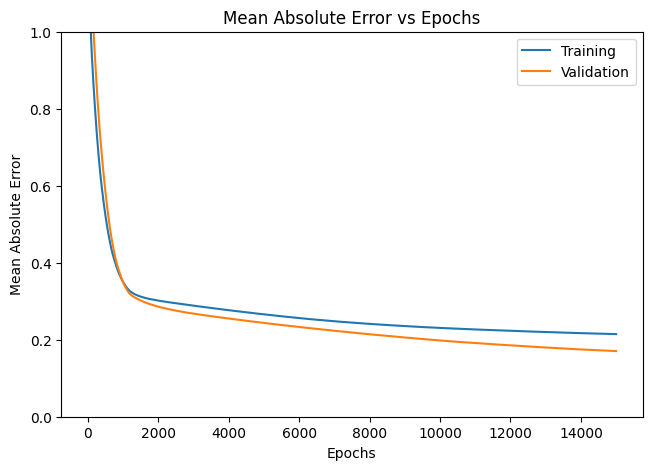

In [31]:
plot_training_curve(J_train, J_val, epochs)

**Question:** You may have noticed that we have implemented the `mean_square_error()` function but seemed to never use it in the training process. Please think about the reason and write it down here.
Hint: double check the deduce process of the Gradient Decent.

In [2]:
# Task 8: answer the question. (1 point in total)

your_answer = (
    # Kontrolle: Keine kontrolle sondern bitte Antwort. # FA: wird eingeführt
"The mean squared error is not actually required for the optimization. \
    What is required is it's derivate which we derived explicitly and used is to calculate the update steps"
#raise NotImplementedError()
)

In [3]:
# 1 point for the answer
assert type(your_answer) == str
assert len(your_answer) > 1

### Accuracy
Now, with the optimized weight vector, let's implement `prediction()` to get the predicted class labels from our linear model. You may need `numpy.dot()` for the computation, and `numpy.round()` to round up the results into integers (because our class labels are integer 0, 1, 2).

In [34]:
# Task 9: implement prediction function. (1 point in total)

def prediction(x, omegaT):
    """
    Return predicted labels.
    
    Args:
        x (numpy.ndarray): the feature matrix (n data points, m features). Shape (n, m)
        omegaT (numpy.ndarray): optimized weight vector (transposed). Shape (m, 1) 
        
    Returns:
        y_pred (numpy.ndarray): predicted labels. Shape (n, 1)
    """
    y_pred = None # please update this in your solution
    # YOUR CODE HERE
    y_pred = (x.dot(omegaT)).round()
    #raise NotImplementedError()
    return y_pred

In [35]:
# 1 point
Y_pred = prediction(X, omegaT)
assert Y_pred.shape == Y.shape

With `Y_pred`. Please implement `accuracy()` that calculates the prediction accuracy.

Hint: prediction accuracy is computed by counting the number of predictions that match the real values, and then devide by the number of total instances.

In [36]:
# Task 10: implement accuracy function. (1 point in total)

def accuracy(y_pred, y):
    """
    Compute the accuracy of prediction.
    
    Args:
        y_pred (numpy.ndarray): the predicted class labels for n data points. Shape (n, 1)
        y (numpy.ndarray): the real class labels. Shape (n, 1)
        
    Returns:
        acc (numpy.float64 or float): calculated accuracy in float.
    """
    acc = None # please update this in your solution
    # YOUR CODE HERE
    acc = np.sum(y_pred == y) / len(y)
    #raise NotImplementedError()
    return acc

In [37]:
acc = accuracy(Y_pred, Y)
acc

[[-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]

0.9333333333333333

In [38]:
assert type(acc) == np.float64 or type(acc) == float

# Hidden test below
# 1 point: test the output value of the accuracy() function

### Visualize predictions vs ground truth
For the last step, let's visualize our predictions v.s. the real labels.

In [39]:
def plot_predict_vs_real(Y_pred, Y):
    """Plot the predictions vs ground truch"""
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.scatter(np.arange(1, 151, 1), Y_pred, label='Predictions')
    ax.plot(np.arange(1, 151, 1), Y, label='Ground Truch', color='red')
    ax.legend(loc="upper left")
    plt.yticks(np.arange(0, 3, 1))
    plt.show()

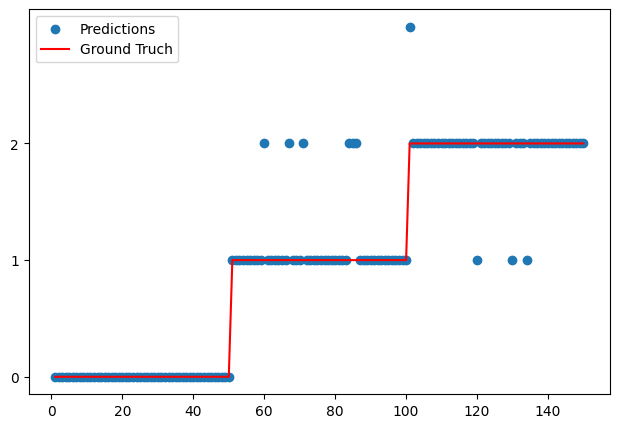

In [40]:
plot_predict_vs_real(Y_pred, Y)

Please feel free to play around with the model and training process. You may adjust the learning rate and number of epochs to see how the trainig curve changes (do not forget to re-initialize the weight vector). You may also try different train-validation split ratio to see the effect.

You may notice that the training results differ a lot with different hyperparameters (learning rate, omega initialization, etc.). This is one limitation of such simple ML model. Later in this semester, you will see and implement more sophisticated ML algorithms that can make more stable and accurate predictions.

## Overfitting & Ridge regression

When finishing this assignment, you may (and may not, depending on the training set setup) sometimes observe the gap between the training curve and validation curve (validation error higher than training error) that cannot be diminished by increasing the number of epochs. This phenomenon is known as "overfitting". It happens when the model gets too complex so that it fits the training set perfectly, but loses the generalization ability towards unseen data from validation/test set.

Ridge regression, also known as L2 regularization, is a useful technique to restrict our model from getting too complicated and reduce the effect of overfitting. It works by simply adding a penalty term to the cost function. In our case, the penalty term is $||\Omega||_2^2$ (the square of the $L^2$ norm). It prefers lower absolute values of weights thus reduce the model complexity. For more information, please refer to [here](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

By introducting the penalty term, our cost function becomes:
\begin{align}
MSE = \frac{1}{2}(\frac{1}{n}\sum^n_{i=1}(\text{y pred}_i - \text{y real}_i)^2 + \lambda ||\Omega||_2^2)
\end{align}
$\lambda$ is the coefficient to adjust the regularization effect.

While the mean absolute error calculation stays the same, the weight update function becomes:
\begin{align}
\Omega = \Omega - \alpha \frac{\partial MSE}{\partial \Omega} = \Omega - \alpha(\frac{1}{n} \sum^n_{i=0}(x_i \Omega^T - \text{y real}_i) x_i + \lambda ||\Omega||_2) 
\end{align}
Now, please implement the new cost function `mean_square_error_ridge()` and `weight_update_function_ridge()` with the penalty term. You may use `mean_square_error()` and `weight_update_function()` that are implemented earlier as references. You may also need `np.square` and `np.sqrt` to calculate square and square root.

In [45]:

# Task 11: implement L2 regularization. (2 points in total)

def mean_square_error_ridge(x, y, omegaT, lam):
    """
    return the mean suqared error.
    
    Args:
        x (numpy.ndarray): numpy array of features (n data points, m features). Shape (n, m)
        y (numpy.ndarray): numpy array of corresponding targets. Shape (n, 1)
        omegaT (numpy.ndarray): weight vector (transposed). shape (m, 1)
        lam (float): ridge regression coefficient.
        
    Returns:
        mse (numpy.float64 or float): mean squared error.
    """
    mse = None # please update this in your solution
    # YOUR CODE HERE
    #    mse = 1/(2*y.shape[0]) * np.sum(np.square(np.dot(x,omegaT)-y))
    error = x.dot(omegaT) - y
    mse = 1/2 * (np.square(error) +  lam * np.sum(np.square(omegaT))).mean()
    #raise NotImplementedError()
    return mse

In [46]:
# 1 point: check the output value
a = np.array([[1.0, 2.0], [2.0, 2.0]])
b = np.array([[1.0], [2.0]])
w = np.array([[1.0, 1.0]]).T
assert np.round(mean_square_error_ridge(a, b, w, 0.1), 1) == 2.1

[[1.]
 [1.]]
2.0
2.0000000000000004


In [109]:
#Kontrolle: ich glaube hier muss noch die Wurzel gezogen werden, da die L2 Norm nicht quadriert wird
def weight_update_function_ridge(x, y, omegaT, alpha, lam):
    """
    return updated set of weights
    
    Args:
        x (numpy.ndarray): numpy array of features (n data points, m features). Shape (n, m)
        y (numpy.ndarray): numpy array of corresponding classes. Shape (n, 1)
        omegaT (numpy.ndarray): weight vector (transposed). Shape (m, 1)
        alpha (float): learning rate.
        lam (float): ridge regression coefficient.
        
    Returns:
        omega_updated (numpy.ndarray): the updated weight vector (transposed). Shape (m, 1)
    """
    omega_updated = None # please update this in your solution
    # YOUR CODE HERE
    error = x.dot(omegaT) - y
    omega_updated = omegaT - alpha* (1/x.shape[0] * x.T.dot(error) + lam * np.sqrt(np.sum(np.square(omegaT))))
    #raise NotImplementedError()
    return omega_updated

In [110]:
# 1 point: check the output value
assert abs(np.mean(weight_update_function_ridge(a, b, w, 0.001, 0.1)) - 0.99) <= 0.01
assert w.shape == weight_update_function_ridge(a, b, w, 0.001, 0.1).shape

Now, let's look at a very unbalanced training set. In this example, only 25 instances are used as training set ($17\%$), and the number of class 0 is significantly higher than both class 1 and 2.

In [111]:
import pickle
with open('iris_overfit', 'rb') as f:
    x_train, x_val, y_train, y_val = pickle.load(f)

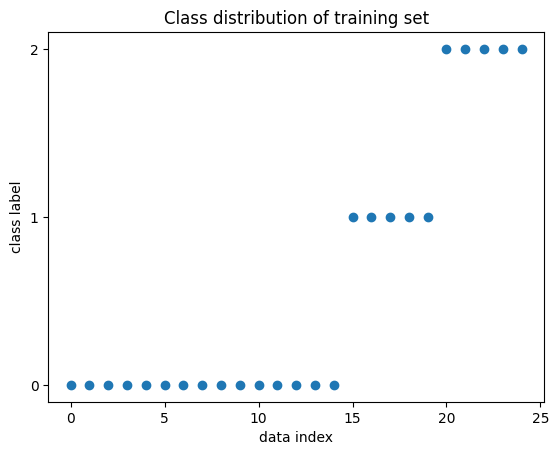

In [112]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, len(y_train), 1), y_train)
plt.yticks(np.arange(0, 3, 1))
ax.set_xlabel("data index")
ax.set_ylabel("class label")
ax.set_title("Class distribution of training set")
plt.show()

For the training, let's do the normal linear regression and ridge regression side by side, with `J_train`, `J_val` recording linear regression training/validation MAE, and `J_train_ridge`, `J_val_ridge` recording ridge regression MAE. Please implement them in the same `for` loop.

In [113]:
np.random.seed(0)
omegaT = np.random.randn(5,1)
epochs = 3000 # number of updates to the weight
alpha = 0.0005 # learning rate
lam = 0.5 # coefficient of L2 penalty
J_train = np.zeros(epochs) # record MAE of training process (without L2 penalty)
J_val = np.zeros(epochs) # record MAE of validation process (without L2 penalty)
J_train_ridge = np.zeros(epochs) # record MAE of training process (with L2 penalty)
J_val_ridge = np.zeros(epochs) # record MAE of validation process (with L2 penalty)

In [118]:
# Task 12: implement training process with L2 regularization. (3 points in total)

omega_norm = np.copy(omegaT) # weight vector for training without L2 penalty
omega_ridge = np.copy(omegaT) # weight vector for ridge regression

for i in range(epochs):
    # for each epoch, record the mae for training and validation process without using ridge regression
    # use the weight_update_function to update the omega_norm
    J_val[i] = None # please update this in your solution
    J_train[i] = None # please update this in your solution
    
    # YOUR CODE HERE
    J_train[i] = mean_absolute_error(x_train, y_train, omega_norm)
    J_val[i] = mean_absolute_error(x_val, y_val, omega_norm)
    omega_norm = weight_update_function(x_train, y_train, omega_norm, alpha)
    #raise NotImplementedError()
    
    # Now, let's try to optimize omega using ridge regression
    # use the weight_update_function_ridge to update the omega_ridge
    J_val_ridge[i] = None # please update this in your solution
    J_train_ridge[i] = None # please update this in your solution
    
    # YOUR CODE HERE 
    # Kontrolle: Werte sind sus
    #def mean_absolute_error_ridge(x, y, omegaT, lam):
        #return ((np.abs(x.dot(omegaT) - y)) + (lam * np.square(np.linalg.norm(omegaT))).sum()).mean()

    J_train_ridge[i] = mean_absolute_error(x_train, y_train, omega_ridge)
    J_val_ridge[i] = mean_absolute_error(x_val, y_val, omega_ridge)
    omega_ridge = weight_update_function_ridge(x_train, y_train, omega_ridge, alpha, lam)

    if ((i % 100 == 0) if i <= 1000 else (i % 2000 == 0)) or i == epochs-1:
        print(f"Epoch {i}: \t  Training MAE = {J_train[i]:.2f},\t Validation MAE = {J_val[i]:.2f},  \t Training_R MAE = {J_train_ridge[i]:.2f}, \tValidation_R MAE = {J_val_ridge[i]:.2f}")
    #raise NotImplementedError()

Epoch 0: 	  Training MAE = 14.36,	 Validation MAE = 17.23,  	 Training_R MAE = 14.36, 	Validation_R MAE = 17.23
Epoch 100: 	  Training MAE = 1.64,	 Validation MAE = 2.54,  	 Training_R MAE = 1.62, 	Validation_R MAE = 2.28
Epoch 200: 	  Training MAE = 1.48,	 Validation MAE = 1.69,  	 Training_R MAE = 1.45, 	Validation_R MAE = 1.41
Epoch 300: 	  Training MAE = 1.29,	 Validation MAE = 1.45,  	 Training_R MAE = 1.23, 	Validation_R MAE = 1.15
Epoch 400: 	  Training MAE = 1.12,	 Validation MAE = 1.26,  	 Training_R MAE = 1.03, 	Validation_R MAE = 0.96
Epoch 500: 	  Training MAE = 0.97,	 Validation MAE = 1.11,  	 Training_R MAE = 0.87, 	Validation_R MAE = 0.80
Epoch 600: 	  Training MAE = 0.84,	 Validation MAE = 0.98,  	 Training_R MAE = 0.72, 	Validation_R MAE = 0.67
Epoch 700: 	  Training MAE = 0.72,	 Validation MAE = 0.86,  	 Training_R MAE = 0.61, 	Validation_R MAE = 0.56
Epoch 800: 	  Training MAE = 0.63,	 Validation MAE = 0.76,  	 Training_R MAE = 0.52, 	Validation_R MAE = 0.48
Epoch 90

In [119]:
# 2 point: check the results of the training process
assert J_train_ridge[-1] > 0
assert np.std(J_val_ridge[-10:]) <= 1e-3 # the model should converge after training

In [120]:
# Hidden test below
# 1 point: further tests of the training results

Now we plot the training curves again, but this time on a log-log scale to better see the differences:

In [107]:
def plot_training_curve_ridge(MAE_train, MAE_val, MAE_train_ridge, MAE_val_ridge, epochs):
    """Plot the mean absolute error for training/validation process"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].loglog(np.arange(epochs), MAE_train, label='Training')
    ax[0].loglog(np.arange(epochs), MAE_val, label='Validation')
    ax[0].set_ylim([0,1])
    ax[0].set_ylabel("Mean Absolute Error")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Without L2 Regularization")
    ax[0].legend(loc='upper right')
    
    ax[1].loglog(np.arange(epochs), MAE_train_ridge, label='Training')
    ax[1].loglog(np.arange(epochs), MAE_val_ridge, label='Validation')
    ax[1].set_ylim([0,1])
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].set_xlabel("Epochs")
    ax[1].set_title("With L2 Regularization")
    ax[1].legend(loc='upper right')
    plt.show()

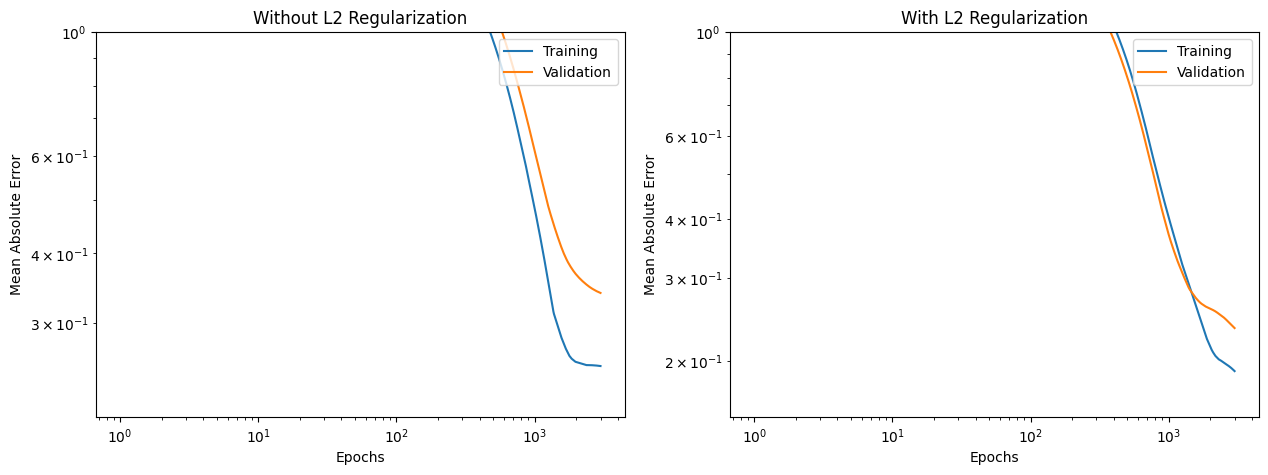

In [108]:
plot_training_curve_ridge(J_train, J_val, J_train_ridge, J_val_ridge, epochs)

In [123]:
Y_pred = prediction(X, omega_norm)
Y_pred_ridge = prediction(X, omega_ridge)
acc = accuracy(Y_pred, Y)
acc_ridge = accuracy(Y_pred_ridge, Y)
print(acc)
print(acc_ridge)

[[-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-1.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [-1.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]

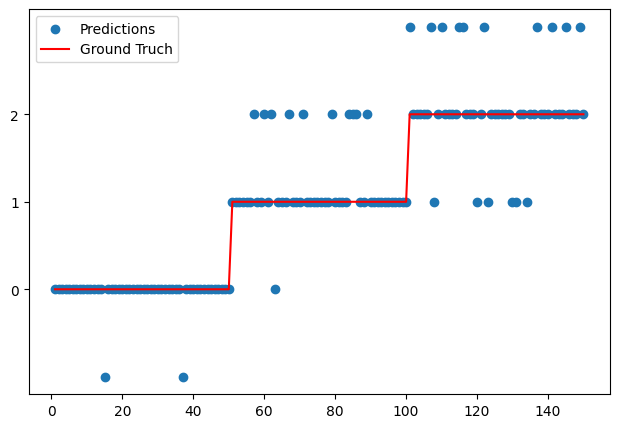

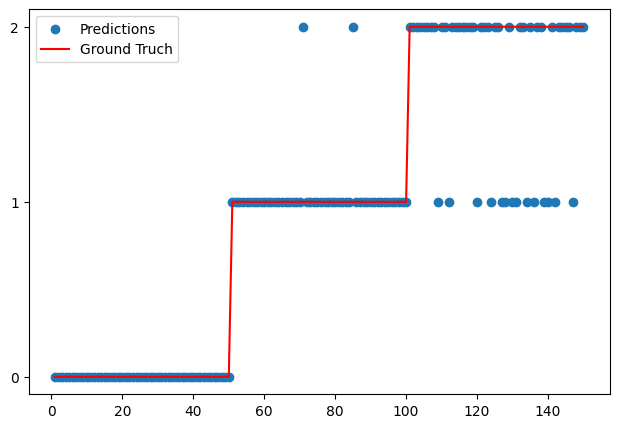

In [126]:
#Frage: ist es normal, dass -1 und 3 predictions sein können?
plot_predict_vs_real(Y_pred, Y)
plot_predict_vs_real(Y_pred_ridge, Y)

**Yes or No question:** from the plots/accuracy calculations, do you think the ridge regression improved the learning performance?

In [127]:
# Task 13: answer the question. (1 point in total)

Answer = (
    # YOUR CODE HERE
    "yes"
    #raise NotImplementedError()
)

In [128]:
# Hidden test below
# 1 point for your answer

## Scipy Optimize

Rather than handcraft the Gradient Decent algorithm, there are libraries that can do the optimization task automatically. The `minimize()` function provided by SciPy library is a good example. It takes as input the name of the function that needs to be minimized, the initial point where the search starts and (optionally) the name of a specific search algorithm. It returns a `OptimizeResult` object that contains details of the optimization result. Below is an example of using `minimize()` function to optimize our linear model.

In [ ]:
from scipy.optimize import minimize

np.random.seed(0)
omega = np.random.randn(1,5)

def mean_square_error(omega):
    return (1/(2*len(X)) * np.sum((np.dot(X, omega.reshape(1,5).T) - Y) ** 2 ))


res = minimize(mean_square_error, omega, method='L-BFGS-B')
print(res)
omega_op = np.array(res.x).reshape(5,1)

In [ ]:
Y_pred = prediction(X, omega_op)
acc = accuracy(Y_pred, Y)
acc

In [ ]:
plot_predict_vs_real(Y_pred, Y)

You can find a good tutorial of SciPy optimization [here](https://machinelearningmastery.com/function-optimization-with-scipy/).  

If you have more questions, please refer to the SciPy [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html).

For the introduction of the "L-BFGS-B" search algorithm using here, please read [this](http://sepwww.stanford.edu/data/media/public/docs/sep117/antoine1/paper_html/node6.html).

***If you want to play around with this library, please do this in a separate notebook that is not submitted!***

Thank you very much for participating the exercise! I hope you find it helpful to understand math basics in machine learning!

Please let us know if you have any thought/comment/suggestion to this exercise by taking the exercise evaluation. Your feedback is valuable to us and is highly appreciated!